#INSA Toulouse - Génie Mathématique et Modélisation - 5A

# **HDDL : High-Dimensional-Deep-Learning**

# **Mini-project n° 4 – RNN, LSTM and GRU vs MLP and CNN**

Mai Dinh Nam  &  El Ghali Berqoq EL Alami

#**Introduction :**

Ce mini-projet a pour but de comparer les performances des architectures récurrentes **RNN**, **LSTM**, **GRU** et autres **MLP** et **CNN** sur l'analyse de sentiments sur le Internet Movie Database, une base de de critiques de films.


Seront pris en compte pour la comparaison plusieurs aspects : **choix des architectures** et **hyperparamètres** mais aussi : **temps de calcul**, **empreinte mémoire** et **précision des prédictions**.

#0. Chargement des données :

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU, BatchNormalization, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# téléchargement du dataset
if not os.path.exists("aclImdb_v1.tar.gz"):
    !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

if not os.path.exists("aclImdb"):
    !tar -xzf aclImdb_v1.tar.gz


def load_imdb_data(path):
    data = []
    for label in ['pos', 'neg']:
        for filename in os.listdir(os.path.join(path, label)):
            with open(os.path.join(path, label, filename), 'r', encoding='utf-8') as f:
                text = f.read()
                data.append([text, label])
    return data

train_data = load_imdb_data('aclImdb/train')
test_data = load_imdb_data('aclImdb/test')

# dataframes
train_df = pd.DataFrame(train_data, columns=['text', 'label'])
test_df = pd.DataFrame(test_data, columns=['text', 'label'])


print("Train DataFrame:")
print(train_df.head())

print("\nTest DataFrame:")
print(test_df.head())


print("Train DataFrame size:", train_df.shape)
print("Test DataFrame size:", test_df.shape)

--2024-12-19 11:51:03--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  13.7MB/s    in 14s     

2024-12-19 11:51:17 (5.83 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Train DataFrame:
                                                text label
0  In this film we have the fabulous opportunity ...   pos
1  On the basis of the preview I'd seen, I went t...   pos
2  Whenever people ask me to name the scariest mo...   pos
3  In his otherwise excellent book, Lincoln in Am...   pos
4  In my years of attending film festivals, I hav...   pos

Test DataFrame:
                                                text label
0  Somewhere in the dark recesses of my

In [ ]:
tokenizer = Tokenizer(num_words=10000)  # on considere les 10000 mots les plus frequents
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

# 300 mots par sequences
maxlen = 300
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Converti les labels en 1/0
y_train = np.array([1 if label == 'pos' else 0 for label in train_df['label']])
y_test = np.array([1 if label == 'pos' else 0 for label in test_df['label']])

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Le DataFrame présenté contient 2 colonnes :

* *text* : Chaque ligne contient une critique de film sous forme de texte.
* *label* : Chaque critique est annotée comme positive (pos) ou négative (neg).

Deux ensembles sont fournis :

* Train DataFrame avec **20 000** critiques pour l'entraînement.
* Validation DataFrame avec **5 000** critiques pour la validation.
* Test DataFrame avec **25 000** critiques pour l'évaluation.


**Taille du vocabulaire (num_words) : 10 000 mots**, le vocaubulaire sera constitué des mots les plus fréquents (sans surrapprendre).


**Longueur des séquences (maxlen) : 300 mots**, pour couvrir suffisamment d'informations par séquence et en évitant des séquences trop longues qui allongeraient le temps d'execution et l'espace en mémoire.


Les données sont constituées d'une base de 25.000 textes de **300 mots** environ.

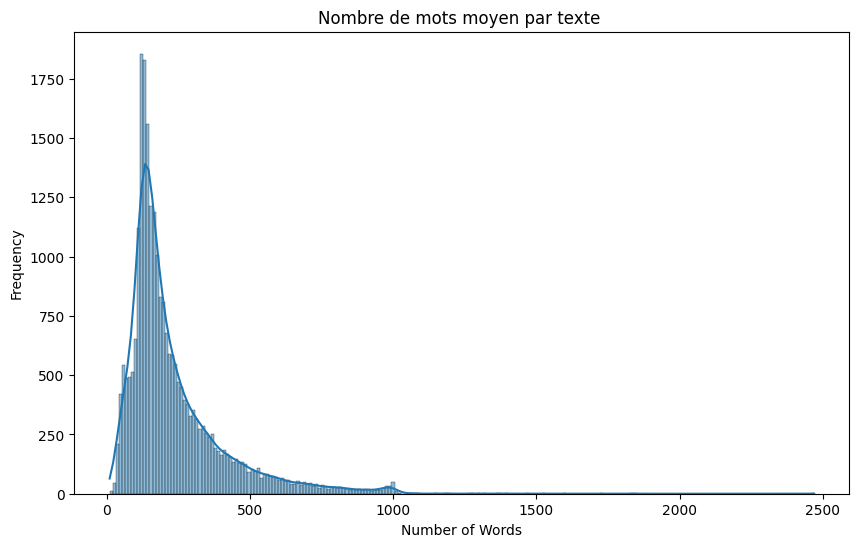

Train DataFrame size: (25000, 3)


In [ ]:
# nombre de mots par texte
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], kde=True)
plt.title('Nombre de mots moyen par texte ')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print("Train DataFrame size:", train_df.shape)

#1. RNN

Nous commençons par un réseau de neurones récurrent **Vanilla**, conçu pour traiter des données séquentielles en mémorisant les dépendances entre les étapes d'une séquence grâce à des boucles internes. Il a l'air bien adapté à notre problème.

**Dimension de l'Embedding (embedding_dim) : 128** plusieurs ont été testées et 128 est le meilleur compromis pour des représentations de mots plus complexe mais toutefois gérable : sans allongement du temps d'execution et l'espace en mémoire.

**Nombre d'unités LSTM (units) : 64**, un bon compromis pour capturer des dépendances tout en limitant la complexité.


**Dropout : 0.3** (sur Embedding et LSTM), pour éviter le surapprentissage en désactivant aléatoirement certaines connexions.


**Taux d'apprentissage (learning_rate) : 0.001**, avec l'optimiseur Adam, qui s’adapte bien à des tâches de classification textuelle.


**Taille des batches (batch_size) : 50.** Ce choix est jugé raisonnable car il représente un diviseur commun entre la taille des ensembles d'entraînement, de validation et de test. Cela garantit une répartition équilibrée des données dans chaque batch tout en optimisant les performances et la consommation de mémoire.


**Nombre d’époques (epochs) : 10**, avec **EarlyStopping** pour arrêter l’entraînement si la performance de validation ne s’améliore pas.

In [ ]:
# RNN avec dropout et regularization
model_RNN = Sequential()
model_RNN.add(Embedding(10000, 128, input_length=maxlen))
model_RNN.add(Dropout(0.3))
model_RNN.add(SimpleRNN(64, dropout=0.3)) # Add dropout to simple RNN layer
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
start_time = time.time()
#Entrainement...
history_RNN = model_RNN.fit(X_train, y_train, epochs=10, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()
# Evaluation...
loss, accuracy = model_RNN.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


execution_time_RNN = end_time - start_time
print(f"Cell execution time: {execution_time_RNN:.2f} seconds")
model_RNN.summary()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.6039 - loss: 0.6415 - val_accuracy: 0.7988 - val_loss: 0.4540
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.8411 - loss: 0.3759 - val_accuracy: 0.8078 - val_loss: 0.4539
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8851 - loss: 0.2888 - val_accuracy: 0.8414 - val_loss: 0.4280
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8830 - loss: 0.2858 - val_accuracy: 0.8068 - val_loss: 0.4900
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9248 - loss: 0.1937 - val_accuracy: 0.8062 - val_loss: 0.5467
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9607 - loss: 0.1121 - val_accuracy: 0.8266 - val_loss: 0.5814
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8377 - loss: 0.4149
Test Loss: 0.4363
Test Accuracy: 0.8300
Cell execution time: 91.69 seconds


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (50, 300, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (50, 300, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (50, 64)                    │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (50, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,877,253 (14.79 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,584,836 (9.86 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8377 - loss: 0.4149
Test Loss: 0.4363
Test Accuracy: 0.8300


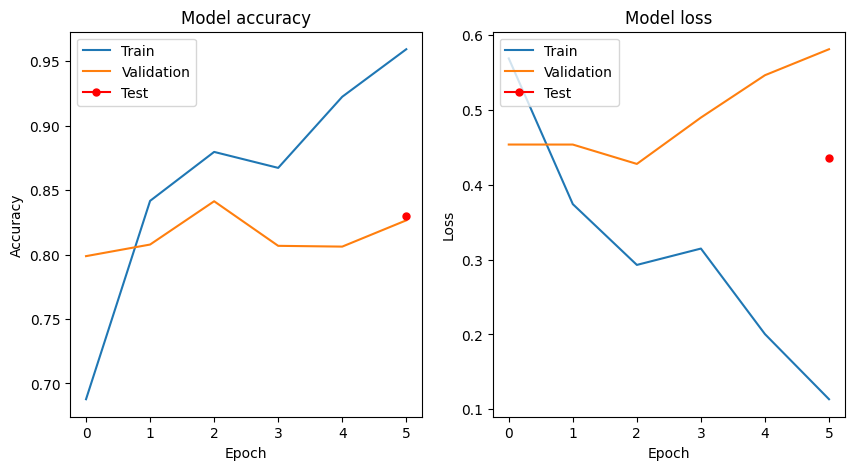

In [ ]:
import matplotlib.pyplot as plt
# Evaluation du modele sur les tests et calcul des metrics
test_loss, test_accuracy = model_RNN.evaluate(X_test, y_test)


print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_RNN.history['accuracy'])
plt.plot(history_RNN.history['val_accuracy'])
plt.plot([len(history_RNN.history['accuracy'])-1], [test_accuracy], marker='o', markersize=5, color='red', label='Test') # Added test accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.plot([len(history_RNN.history['loss'])-1], [test_loss], marker='o', markersize=5, color='red', label='Test') # Added test loss
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

A travers des tests d'hyper-paramètres les résultats obtenues semblent converger vers de très bons scores à l'entraînement et des scores un peu moins bons pour le test. Il y a donc un **écart de moins de 13%** sur l'accuracy du modèle entre l'entraînement et le test et de moins de 0.32 entre les pertes remarquées.


Le risque de surapprentissage est toujours présent malgré l'**EarlyStopping** qui a arrêté l'entrainement au bout de 2 epochs sans amélioration des performances. Néanmoins le score de l'Accuracy au test est de **+ 0.83** ce qui est très bien.

**Avantages :**

- Consommation mémoire faible.  


**Inconvénients :**

- Temps d'entraînement relativement élevé (cependant, cela pourrait être dû à des problème de Google Colab, car sur Kaggle, l'entraînement Vanilla est plus rapide comparé à LSTM et GRU .En effet, en théorie, Vanilla RNN effectue des calculs plus simples que LSTM et GRU).

- Performances inférieures à celles des autres méthodes, perte élevée et précision plus faible .

#2. LSTM :

On utilise désormais un modèle RNN avec LSTM (Long Short-Term Memory) pour la classification binaire des avis IMDB en positifs et négatifs. La préparation des données s’appuie sur une **tokenization qui sélectionne les 10000 mots les plus fréquents**, suivie d’un **padding** pour uniformiser les séquences à une longueur de **150 mots**. Les labels sont convertis en valeurs binaires (1 pour positif, 0 pour négatif), et les données sont séparées en train, validation et test.

L’architecture du modèle intègre une couche **Embedding** qui transforme les tokens en vecteurs de dimension 128 pour capturer des représentations denses des mots. Une **couche LSTM avec 64 neurones** est utilisée pour **apprendre les dépendances temporelles dans les données textuelles,** accompagnée d’un Dropout de 0.3 pour éviter le sur-apprentissage.

Le modèle est compilé avec l’optimiseur **Adam** et une fonction de perte **binary cross-entropy** adaptée à la classification binaire. Un mécanisme d’**EarlyStopping** surveille la perte sur les données de validation et arrête l’apprentissage lorsque celle-ci ne s’améliore plus.

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]$$

Où :

* $N$ : Le nombre total d'exemples dans le batch.
* $y_i$ : La vraie étiquette pour l'exemple $i$ (0 ou 1).
* $\hat{y}_i$ : La probabilité prédite par le modèle pour l'exemple $i$ (entre 0 et 1).



Lors de l’entraînement, l'ajout de l**a couche LSTM** permetra au modèle de **capturer le contexte des mots dans une phrase** ce qui améliore considérablement la performance par rapport à des modèles plus simples.

**Les + à priori :**

+ Performance élevée grâce à la gestion les dépendances séquentielles.

+ Meilleure compréhension du contexte dans les textes.

**Les - à priori :**

- Temps d’exécution relativement long à cause de la nature séquentielle des LSTM.

- Coût plus élevé comparé aux architectures plus simples.


In [ ]:
# Définition des paramètres
vocab_size_LSTM = 10000  # Vocabulaire de 10 000 mots
embedding_dim_LSTM = 128  # Taille des embeddings
maxlen_LSTM = 300  # Longueur des séquences (300 mots)
lstm_units_LSTM = 64  # Nombre d'unités LSTM
dropout_rate_LSTM = 0.3  # Taux de Dropout
batch_size_LSTM = 50  # Taille des batches
epochs_LSTM = 10  # Nombre d'époques
learning_rate_LSTM = 0.001  # Taux d'apprentissage
early_stopping_LSTM = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Création du modèle LSTM
model_LSTM = Sequential([
    Embedding(input_dim=vocab_size_LSTM, output_dim=embedding_dim_LSTM, input_length=maxlen_LSTM),
    Dropout(dropout_rate_LSTM),  # Dropout sur la couche Embedding
    LSTM(lstm_units_LSTM, dropout=dropout_rate_LSTM),  # LSTM avec Dropout
    Dense(1, activation='sigmoid')  # Couche de sortie avec activation sigmoïde
])

# Compilation du modèle
model_LSTM.compile(optimizer=Adam(learning_rate=learning_rate_LSTM), loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
# Entraînement du modèle
history_LSTM = model_LSTM.fit(
    X_train, y_train,
    epochs=epochs_LSTM,
    batch_size=batch_size_LSTM,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_LSTM]
)
end_time = time.time()
# Évaluation sur les données de test
test_loss_LSTM, test_accuracy_LSTM = model_LSTM.evaluate(X_test, y_test)
print(f"Test Loss (LSTM): {test_loss_LSTM:.4f}")
print(f"Test Accuracy (LSTM): {test_accuracy_LSTM:.4f}")

execution_time_LSTM = end_time - start_time
print(f"Cell execution time: {execution_time_LSTM:.2f} seconds")
model_LSTM.summary()

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7214 - loss: 0.5181 - val_accuracy: 0.8730 - val_loss: 0.3179
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8981 - loss: 0.2581 - val_accuracy: 0.8824 - val_loss: 0.3028
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9240 - loss: 0.2045 - val_accuracy: 0.8844 - val_loss: 0.2997
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9428 - loss: 0.1610 - val_accuracy: 0.8792 - val_loss: 0.3394
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9548 - loss: 0.1286 - val_accuracy: 0.8808 - val_loss: 0.3699
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9638 - loss: 0.1053 - val_accuracy: 0.8672 - val_loss: 0.4432
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8795 - loss: 0.2948
Test Loss (LSTM): 0.3167
Test Accuracy (LSTM): 0.8745
Cell execution time: 60.06 seconds


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (50, 300, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (50, 300, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (50, 64)                    │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (50, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,421 (15.21 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,658,948 (10.14 MB)

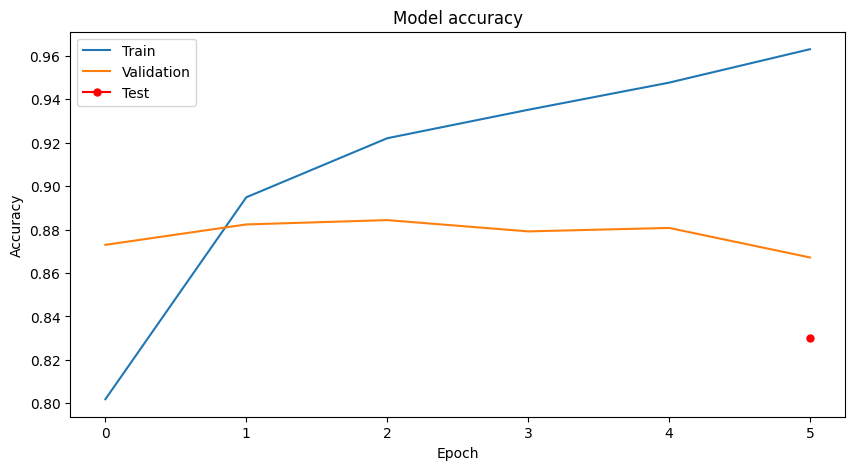

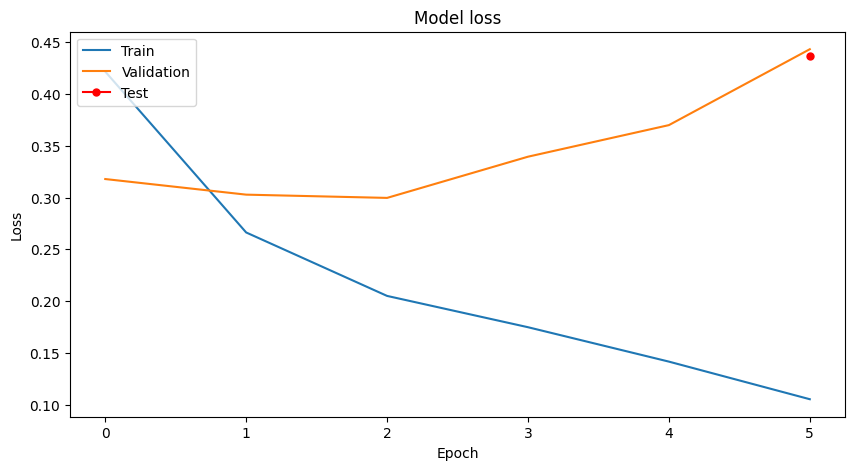

In [ ]:
# Plot les précisions des entraînement et validation
plt.figure(figsize=(10, 5))
plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.plot([len(history_LSTM.history['accuracy'])-1], [test_accuracy], marker='o', markersize=5, color='red', label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')


# Plot les valeurs de pertes des entraînement et validation
plt.figure(figsize=(10, 5))
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.plot([len(history_LSTM.history['loss'])-1], [test_loss], marker='o', markersize=5, color='red', label='Test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

Le risque de surapprentissage est toujours présent malgré l'EarlyStopping qui a limité les frais. Néanmoins, le score de l'Accuracy au test pour le modèle LSTM est de **0.87**, ce qui est meilleur que le RNN.


**Avantages :**

+ Bonne précision.  
+ Perte minimale.  
+ Consommation mémoire faible.  

**Inconvénients :**

- Temps d'entraînement moyen (~60 secondes).

#3. GRU :

On passe désormais un modèle GRU (Gated Recurrent Unit) en exploitant une structure récurrente adaptée au traitement séquentiel. **Comme pour les autres modèles**, les données sont préparées via une **tokenization des 10 000 mots** les plus fréquents et un **padding** pour uniformiser les séquences à une longueur maximale de 300 mots. Les labels sont convertis en valeurs binaires.

L’architecture du modèle GRU se compose des éléments suivants :

* Une couche **Embedding** avec une dimension de 128 pour capturer les représentations vectorielles des mots.

* Une couche **GRU avec 64 unités**, qui intègre des mécanismes de portes pour capturer efficacement les dépendances temporelles tout en limitant le problème de gradient évanescent.

* Un **Dropout** de 0.3 est appliqué dans la couche GRU pour réduire les risques de sur-apprentissage.

* Une couche de sortie dense activée par une fonction **Sigmoid** permet de produire une probabilité binaire.


$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$


Où :

$$z = \mathbf{w} \cdot \mathbf{x} + b$$

- $\hat{y}$ représente la probabilité prédite par le modèle (entre 0 et 1).
- $z$ est la sortie linéaire du neurone.
- $\mathbf{w}$ est le vecteur des poids.
- $\mathbf{x}$ est le vecteur des entrées.
- $b$ est le biais.


Le modèle est compilé avec un optimiseur **Adam** (intégrant un clipping des gradients pour une meilleure stabilité), et l’entraînement utilise un mécanisme **EarlyStopping** qui arrête l'apprentissage si la perte de validation n’améliore plus après 3 époques.


In [ ]:
# Définition des paramètres
vocab_size_GRU = 10000  # Vocabulaire de 10 000 mots
embedding_dim_GRU = 128  # Taille des embeddings
maxlen_GRU = 300  # Longueur des séquences (300 mots)
gru_units_GRU = 64  # Nombre d'unités GRU
dropout_rate_GRU = 0.3  # Taux de Dropout
batch_size_GRU = 50  # Taille des batches
epochs_GRU = 10  # Nombre d'époques
learning_rate_GRU = 0.001  # Taux d'apprentissage
early_stopping_GRU = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


#RNN avecdropout et regularisation
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size_GRU, embedding_dim_GRU, input_length=maxlen_GRU))
model_GRU.add(Dropout(dropout_rate_GRU))
model_GRU.add(GRU(gru_units_GRU, dropout=dropout_rate_GRU))  # Replace LSTM with GRU
model_GRU.add(Dense(1, activation='sigmoid'))


# optimizer = Adam(clipnorm=0.1) # Add gradient clipping
optimizer=Adam(learning_rate=learning_rate_GRU)
model_GRU.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


start_time = time.time()
#Entraînement
history_GRU = model_GRU.fit(X_train, y_train, epochs=10, batch_size=batch_size_GRU, validation_data=(X_val, y_val), callbacks=[early_stopping_GRU])
end_time = time.time()


# Évaluation sur les données de test
test_loss_GRU, test_accuracy_GRU = model_GRU.evaluate(X_test, y_test)
print(f"Test Loss (GRU): {test_loss_GRU:.4f}")
print(f"Test Accuracy (GRU): {test_accuracy_GRU:.4f}")

execution_time_GRU = end_time - start_time
print(f"Cell execution time: {execution_time_GRU:.2f} seconds")

model_GRU.summary()

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6901 - loss: 0.5594 - val_accuracy: 0.8734 - val_loss: 0.3206
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8905 - loss: 0.2699 - val_accuracy: 0.8832 - val_loss: 0.2941
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9301 - loss: 0.1873 - val_accuracy: 0.8764 - val_loss: 0.3446
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9436 - loss: 0.1504 - val_accuracy: 0.8962 - val_loss: 0.2872
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9701 - loss: 0.0915 - val_accuracy: 0.8888 - val_loss: 0.3216
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9787 - loss: 0.0674 - val_accuracy: 0.8862 - val_loss: 0.4183
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9826 - loss: 0.0525 - val_accuracy: 0.8878 - val_loss: 0.4034
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8651 - loss: 0.3652
Test Loss (GRU): 0.3

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (50, 300, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (50, 300, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (50, 64)                    │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (50, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,951,941 (15.08 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,634,628 (10.05 MB)

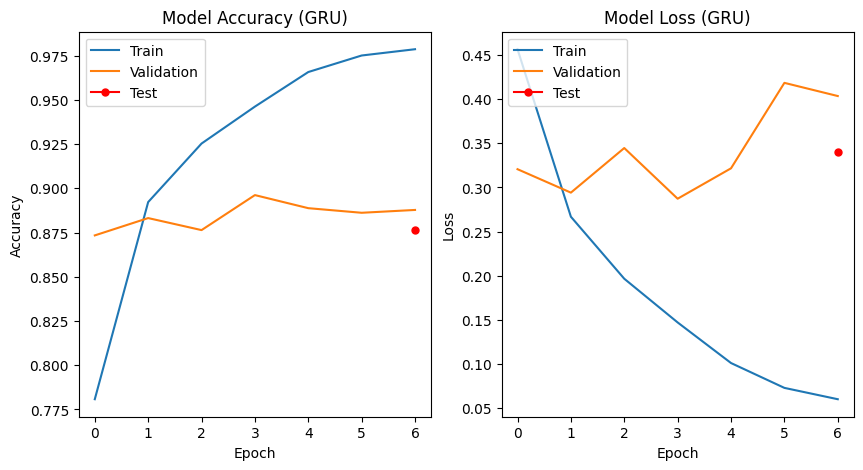

In [ ]:
# Visualisation de la courbe de perte et d'exactitude
#Précision d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.plot([len(history_GRU.history['accuracy'])-1], [test_accuracy_GRU], marker='o', markersize=5, color='red', label='Test') # Added test accuracy
plt.title('Model Accuracy (GRU)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

# Perte d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.plot([len(history_GRU.history['loss'])-1], [test_loss_GRU], marker='o', markersize=5, color='red', label='Test') # Added test loss
plt.title('Model Loss (GRU)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()



Le modèle GRU atteint une précision et une perte comparables à celles du modèle LSTM, mais avec un temps d’exécution plus court grâce à une structure plus simple et efficace.

Une précision d’environ 87% est obtenue sur les données de test, confirmant que le GRU est capable de capturer les relations contextuelles essentielles dans le texte.

**Avantages :**

+ Bon compromis entre précision et perte faible.

+ Consommation mémoire faible.

**Inconvénients :**

- Temps d'entraînement moyen (~55 secondes), meilleur que LSTM.


#4. MLP :

Nous implémentons désormais un Multi-Layer Perceptron. Les données textuelles ont d’abord été préparées grâce à une **tokenization** qui sélectionne les **10 000 mots les plus fréquents**, suivie d’un **padding** pour uniformiser les séquences à une longueur maximale de **300 mots**.

Les labels ont été convertis en valeurs binaires (1 pour positif, 0 pour négatif).

L’architecture du modèle est simple et est constituée de **2 couches denses**avec respectivement 256 et 128 neurones **activés par la fonction ReLU**, accompagnées de couches **Dropout** avec un **taux de 0.3 pour éviter le sur-apprentissage**. La couche de sortie utilise **une activation sigmoid** pour produire la probabilité d’appartenance à l’une des deux classes.

L’entraînement du modèle a été effectué avec l’**optimiseur Adam** et un mécanisme **EarlyStopping** qui arrête l’apprentissage lorsque la perte de validation n’améliore plus. Grâce à cette architecture optimisée, le modèle atteint une précision d’environ 85% à 90% sur les données de test.

L'avantage a priori de cette méthode réside dans l'utilisation du modèle ANN traditionnel, qui permet un calcul parallèle grâce au GPU, ce qui peut potentiellement accélérer les résultats. Toutefois, elle présente certaines limites : elle ne prend pas en compte les relations temporelles ou contextuelles dans les données textuelles, ce qui peut affecter ses performances dans notre tâche de classification.

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5075 - loss: 0.9278 - val_accuracy: 0.5726 - val_loss: 0.6862
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7046 - loss: 0.5688 - val_accuracy: 0.8432 - val_loss: 0.3611
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9334 - loss: 0.1769 - val_accuracy: 0.8446 - val_loss: 0.3726
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9764 - loss: 0.0735 - val_accuracy: 0.8574 - val_loss: 0.4039
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9949 - loss: 0.0250 - val_accuracy: 0.8490 - val_loss: 0.4596
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9967 - loss: 0.0157 - val_accuracy: 0.8438 - val_loss: 0.5211
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9962 - loss: 0.0149 - val_accuracy: 0.8478 - val_loss: 0.5277
Cell execution time: 21.12 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8130 - loss: 0

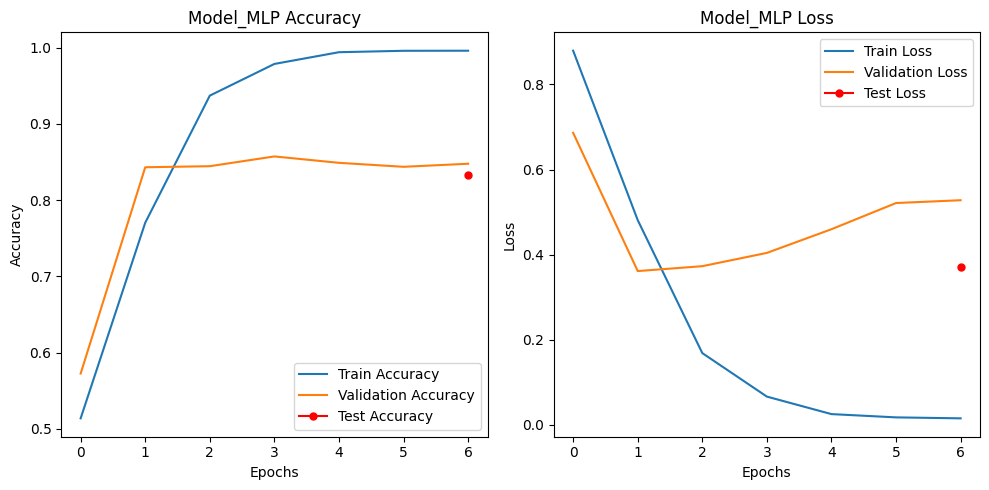

In [ ]:
maxlen_MLP = 300  # Fixer une longueur maximale de 300 mots

#modèle MLP
model_MLP = Sequential()

# Couche Embedding pour convertir les mots en vecteurs
model_MLP.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen_MLP))

# Aplatissement des vecteurs d'embedding pour les passer dans un MLP
model_MLP.add(Flatten())

# Première couche dense
model_MLP.add(Dense(256, activation='relu'))
model_MLP.add(BatchNormalization())  # Normalisation pour améliorer la stabilité de l'entraînement
model_MLP.add(Dropout(0.5))  # Dropout pour éviter le sur-apprentissage

# Deuxième couche dense
model_MLP.add(Dense(128, activation='relu'))
model_MLP.add(BatchNormalization())
model_MLP.add(Dropout(0.5))

# Couche de sortie pour la classification binaire
model_MLP.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
optimizer = Adam(learning_rate=0.0003)  # Réduction du taux d'apprentissage
model_MLP.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Définir EarlyStopping pour arrêter si le modèle sur-apprend
early_stopping_MLP = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time = time.time()
# Entraîner le modèle
history_MLP = model_MLP.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=50,  # Augmentation de la taille de batch  ++++
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_MLP]
)

end_time = time.time()
execution_time_MLP = end_time - start_time
print(f"Cell execution time: {execution_time_MLP:.2f} seconds")

# Évaluer le modèle
loss_MLP, accuracy_MLP = model_MLP.evaluate(X_test, y_test)
print(f"Test Loss_MLP: {loss_MLP:.4f}")
print(f"Test Accuracy_MLP: {accuracy_MLP:.4f}")

#courbes d'entraînement
plt.figure(figsize=(10, 5))
# Précision
plt.subplot(1, 2, 1)
plt.plot(history_MLP.history['accuracy'], label='Train Accuracy')
plt.plot(history_MLP.history['val_accuracy'], label='Validation Accuracy')
plt.plot([len(history_MLP.history['accuracy'])-1], [accuracy_MLP], marker='o', markersize=5, color='red', label='Test Accuracy')
plt.title('Model_MLP Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_MLP.history['loss'], label='Train Loss')
plt.plot(history_MLP.history['val_loss'], label='Validation Loss')
plt.plot([len(history_MLP.history['loss'])-1], [loss_MLP], marker='o', markersize=5, color='red', label='Test Loss')
plt.title('Model_MLP Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

On remarque que la précision est stable autour de 0.84 pour la validation  et que la perte est vers 0.5

**Avantages :**

+ Temps d'exécution **très rapide**.

**Inconvénients :**

-  Utilisation élevée de la mémoire

- Performances inférieures à celles des autres méthodes, perte élevée et précision plus faible .

#5. CNN 1D

Finalement, nous implémentons un réseau de neurones convolutifs (CNN) pour la classification de sentiments sur le jeu de données IMDB. Les données textuelles ont d’abord été préparées grâce à une **tokenisation qui sélectionne les 10 000 mots** les plus fréquents, suivie d’un **padding** pour uniformiser les séquences à une longueur maximale de **300 mots**. Les labels ont été convertis en valeurs binaires (1 pour positif, 0 pour négatif).


L’architecture du modèle est composée d’une couche d’**embedding** pour représenter les mots sous forme de vecteurs, suivie d’une **couche convolutive** avec **128 filtres et une taille de noyau de 5**. Après une opération de max pooling pour réduire la dimensionnalité, un **dropout** de 0.3 est appliqué pour éviter le sur-apprentissage.

Une couche de global **max pooling** est utilisée pour capturer les caractéristiques principales, suivie d’une **couche dense de 128 neurones** **activée par ReLU.** Une **2ème couche dropout** est ajoutée pour prévenir le sur-apprentissage, et enfin, la couche de sortie utilise une **activation sigmoïde** pour la classification binaire.


L’entraînement du modèle a été effectué avec l’optimiseur **Adam** et la fonction de perte **binaire cross-entropy**. Un mécanisme **EarlyStopping** a été ajouté pour stopper l’entraînement si la perte de validation cesse d’améliorer. Le modèle a été entraîné pendant **20 époques** avec un **batch size de 64**. Après l’entraînement, le modèle atteint une précision d’environ 85 % à 90 % sur les données de test.


Le modèle **CNN** présente plusieurs avantages. Il est capable de capturer des relations locales entre les mots grâce aux **filtres convolutifs**, ce qui le rend plus adapté que le **MLP** pour les données textuelles. De plus, la structure du **CNN** permet de réduire le nombre de paramètres par rapport à un **MLP**, ce qui permet d'entraîner le modèle avec une **consommation de mémoire plus faible**.

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6581 - loss: 0.5709 - val_accuracy: 0.8738 - val_loss: 0.3063
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9251 - loss: 0.1935 - val_accuracy: 0.8970 - val_loss: 0.2580
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9770 - loss: 0.0764 - val_accuracy: 0.8930 - val_loss: 0.2770
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9942 - loss: 0.0257 - val_accuracy: 0.8978 - val_loss: 0.2886
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9975 - loss: 0.0117 - val_accuracy: 0.8928 - val_loss: 0.3360
Cell execution time: 21.02 seconds
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9192 - loss: 0.2165
Test Loss_CNN: 0.2719
Test Accuracy_CNN: 0.8880


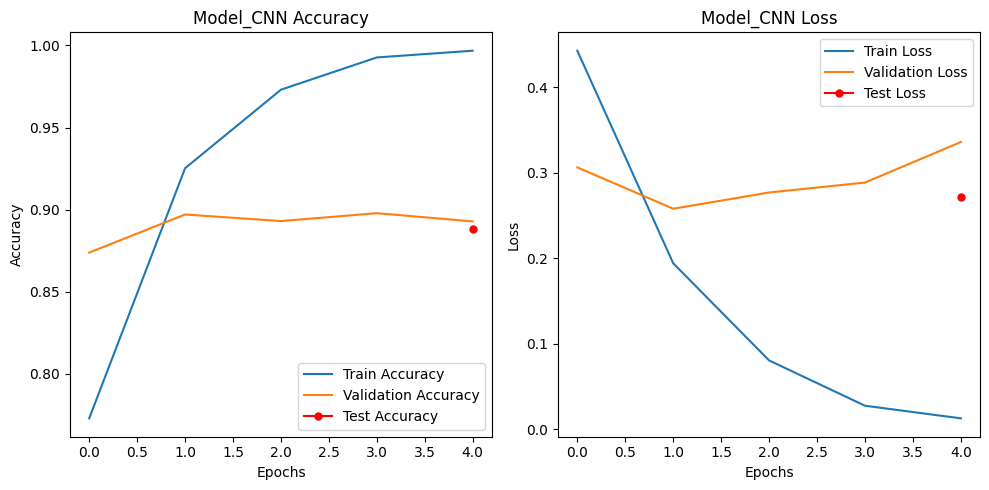

In [ ]:
maxlen_CNN=300

# Construire le modèle CNN 1D
model_CNN = Sequential()
model_CNN.add(Embedding(10000, 128, input_length=maxlen_CNN))  # Embedding pour représenter les mots sous forme de vecteurs
model_CNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))  # Couche convolutive
model_CNN.add(MaxPooling1D(pool_size=2))  # Pooling pour réduire la dimensionnalité
model_CNN.add(Dropout(0.3))  # Dropout pour éviter le surapprentissage
model_CNN.add(GlobalMaxPooling1D())  # Pooling global pour capturer les caractéristiques principales
model_CNN.add(Dense(128, activation='relu'))  # Couche dense intermédiaire
model_CNN.add(Dropout(0.3))  # Dropout supplémentaire
model_CNN.add(Dense(1, activation='sigmoid'))  # Couche de sortie pour la classification binaire

# Compiler le modèle
model_CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Définir EarlyStopping pour arrêter si le modèle sur-apprend
early_stopping_CNN = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()

# Entraîner le modèle
history_CNN = model_CNN.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_CNN]
)

end_time = time.time()
execution_time_CNN = end_time - start_time
print(f"Cell execution time: {execution_time_CNN:.2f} seconds")

# Évaluer le modèle
loss_CNN, accuracy_CNN = model_CNN.evaluate(X_test, y_test)
print(f"Test Loss_CNN: {loss_CNN:.4f}")
print(f"Test Accuracy_CNN: {accuracy_CNN:.4f}")

#courbes d'entraînement
plt.figure(figsize=(10, 5))
# Précision
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.plot([len(history_CNN.history['accuracy'])-1], [accuracy_CNN], marker='o', markersize=5, color='red', label='Test Accuracy') # Ajout de la précision de test
plt.title('Model_CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['loss'], label='Train Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.plot([len(history_CNN.history['loss'])-1], [loss_CNN], marker='o', markersize=5, color='red', label='Test Loss') # Ajout de la perte de test
plt.title('Model_CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Avantages :**

+ Meilleure précision et perte plus faible.

+ Temps d'exécution faible.

+ Utilisation mémoire faible.


#6. Qui est le meilleur ?

## 6.1. Performances :

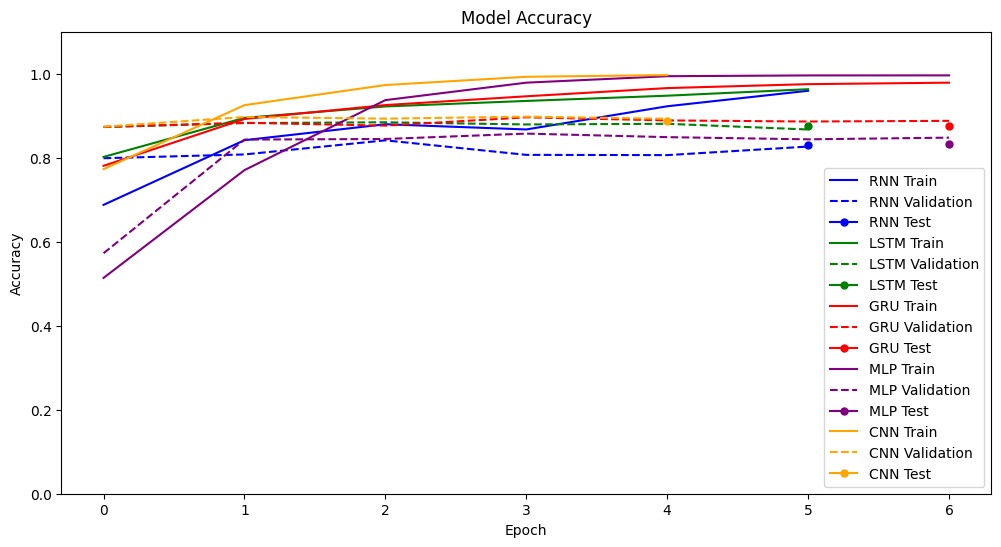

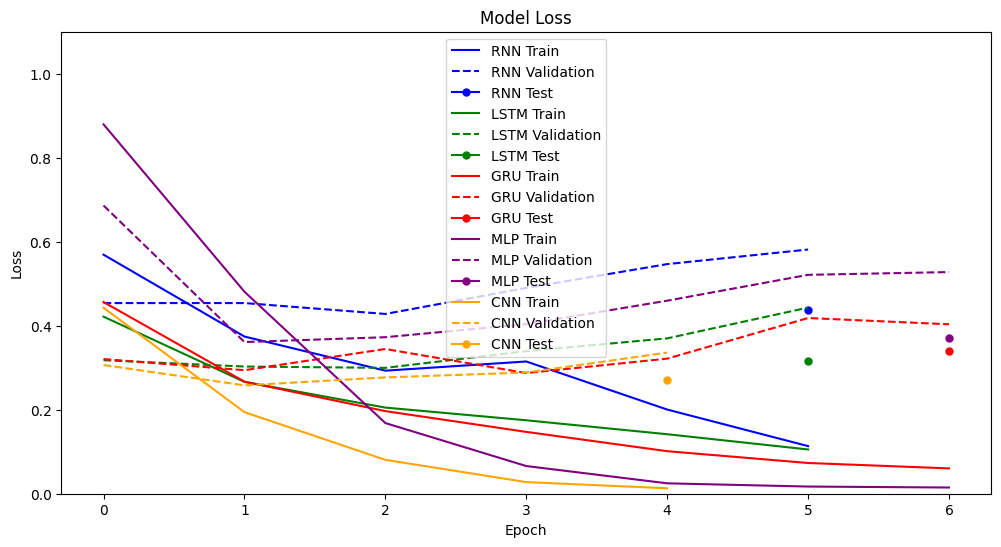

In [ ]:
import matplotlib.pyplot as plt

models_history = {
    'RNN': history_RNN,
    'LSTM': history_LSTM,
    'GRU': history_GRU,
    'MLP': history_MLP,
    'CNN': history_CNN

}

test_metrics = {
    'RNN': (test_loss, test_accuracy),
    'LSTM': (test_loss_LSTM, test_accuracy_LSTM),
    'GRU': (test_loss_GRU, test_accuracy_GRU),
    'MLP': (loss_MLP, accuracy_MLP),
    'CNN': (loss_CNN, accuracy_CNN)
}

colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(12, 6))

# Plot précisions
for i, (model_name, history) in enumerate(models_history.items()):
    plt.plot(history.history['accuracy'], label=f'{model_name} Train', color=colors[i])
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation', linestyle='--', color=colors[i])
    test_loss, test_accuracy = test_metrics[model_name]
    plt.plot([len(history.history['accuracy'])-1], [test_accuracy], marker='o', markersize=5, color=colors[i], label=f'{model_name} Test')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

#Plot pertes
for i, (model_name, history) in enumerate(models_history.items()):
    plt.plot(history.history['loss'], label=f'{model_name} Train', color=colors[i])
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation', linestyle='--', color=colors[i])
    test_loss, test_accuracy = test_metrics[model_name]
    plt.plot([len(history.history['loss'])-1], [test_loss], marker='o', markersize=5, color=colors[i], label=f'{model_name} Test')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1.1)
plt.legend()
plt.show()


* **A l'entraînement :**

Les courbes montrent que les modèles atteignent des performances proches, mais certains se stabilisent à des niveaux plus élevés.
**Le modèle CNN semble avoir la meilleure performance globale**, suivi par LSTM et GRU.
Les modèles MLP et RNN semblent avoir une précision légèrement inférieure, particulièrement sur les données de test.

* **Validation et généralisation :**

Les courbes de validation et de test des modèles **CNN** montrent les meilleures performances, suivies de près par **LSTM** et **GRU**, tandis que le **MLP** et le **RNN** ont des performances plus faibles. Le MLP montre un léger écart entre les performances d'entraînement et de validation, ce qui peut être un signe de sur-apprentissage.

* **En termes de stabilité :**

Le CNN atteint rapidement une haute précision et reste stable.
Le LSTM et GRU met légèrement plus de temps, mais finit par converger vers des bonnes résultats.


* **Analyse des pertes :**

La courbe de perte diminue régulièrement pour tous les modèles, mais le CNN et le LSTM montrent une convergence plus rapide. Les pertes des modèles RNN et MLP semblent diminuer plus lentement, avec un écart notable entre l'entraînement et la validation.


* **Conclusion :**

**"+"** Meilleur modèle : Le **CNN semble offrir la meilleure combinaison de précision, stabilité, et vitesse de convergence.** Il généralise bien et conserve une performance élevée sur les données de test.


**"+"** Alternatives compétitives : Les **LSTM et GRU** offrent également de bons résultats, particulièrement dans des scénarios nécessitant des séquences temporelles plus complexes.

**"-"** Modèles à éviter : Le **RNN** est moins performant et montre une **instabilité** dans ses prédictions. Le MLP, bien qu'intéressant, semble moins adapté pour des données séquentielles comme celles de ce projet.


**=> Pour l'amélioration globale, combiner ces modèles via le vote majoritaire pourrait encore renforcer les performances globales en tirant parti des points forts de chaque architecture.**

## 6.2. Temps d'execution :

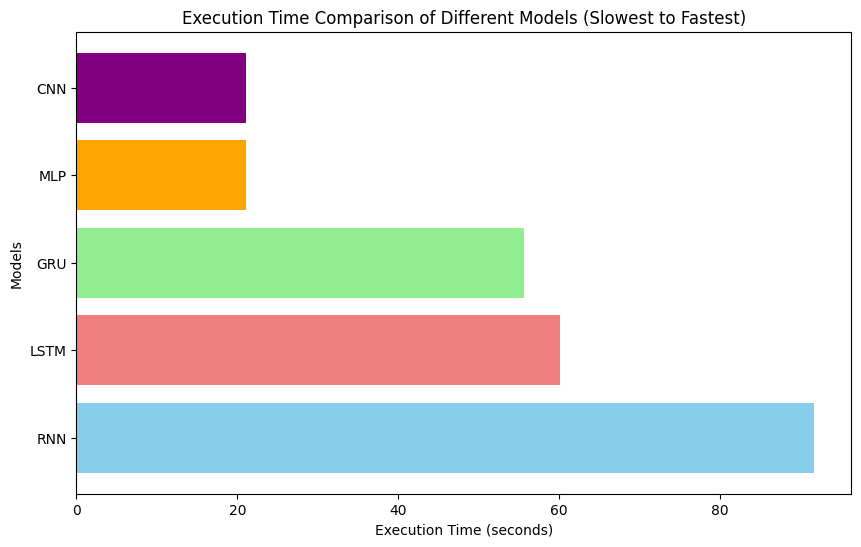

In [ ]:
import matplotlib.pyplot as plt
execution_times = {
    'GRU': execution_time_GRU,
    'MLP': execution_time_MLP,
    'CNN': execution_time_CNN,
    'LSTM': execution_time_LSTM,
    'RNN': execution_time_RNN,
}
#TRI
sorted_execution_times = dict(sorted(execution_times.items(), key=lambda item: item[1], reverse=True))

models = list(sorted_execution_times.keys())
times = list(sorted_execution_times.values())

plt.figure(figsize=(10, 6))
plt.barh(models, times, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple']) # Add more colors as needed
plt.xlabel("Execution Time (seconds)")
plt.ylabel("Models")
plt.title("Execution Time Comparison of Different Models (Slowest to Fastest)")
plt.show()

En termes de temps d'execution,

* Les modèles **CNN, MLP** sont ex æquo et les plus rapides. Les **CNN** bénéficient de leur simplicité et de leur capacité à effectuer des calculs **parallèles**, ce qui accélère l'exécution, surtout sur des GPUs.

* Ils sont tous les deux suivis des modèles **GRU et LSTM**, bien qu’ils soient capables de gérer des dépendances temporelles complexes, ils prennent probablement plus de temps à cause de leur structure plus complexe, avec des **portes** (notamment dans les LSTM), qui ralentit le traitement des séquences. De plus, contrairement aux modèles comme **CNN** ou **MLP**, ces modèles ne peuvent pas effectuer de calculs parallèles et doivent traiter les séquences de manière **séquentielle**, ce qui augmente encore le temps d'exécution.

* Finalement le **RNN** est le plus lent, cela pourrait être dû à des problème de Google Colab, car sur Kaggle, l'entraînement Vanilla est plus rapide comparé à **LSTM** et **GRU** .En effet, en théorie, **Vanilla RNN** effectue des calculs plus simples que **LSTM** et **GRU**.

In [ ]:
batch_size=64
import numpy as np

def calculate_memory_usage(model, batch_size, input_length, dtype_size=4):
    # Taille des poids
    total_params = model.count_params()
    memory_weights = total_params * dtype_size

    # Taille des activations intermédiaires
    total_activations = sum(
        [np.prod(layer.output_shape[1:]) if hasattr(layer, 'output_shape') and layer.output_shape is not None
         else np.prod([layer.output_dim, input_length, batch_size]) if isinstance(layer, type(model.layers[0])) and isinstance(layer, type(model_LSTM.layers[0])) and isinstance(layer, type(model_GRU.layers[0])) and isinstance(layer, type(model_CNN.layers[0]))  # Assuming Embedding is the first layer and layer for LSTM, GRU, CNN models
         else 0  # For layers without output_shape
         for layer in model.layers]
    )
    memory_activations = total_activations * dtype_size

    # Taille des gradients (équivalent aux poids pendant l'entraînement)
    memory_gradients = memory_weights

    # Mémoire totale
    total_memory = (memory_weights + memory_activations + memory_gradients) / (1024 ** 2)  # Conversion en Mo
    return total_memory


memory_RNN = calculate_memory_usage(model_RNN, batch_size, maxlen)
print(f"Memory Usage for RNN (MB): {memory_RNN:.2f}")

# Après la création du modèle RNN
memory_MLP = calculate_memory_usage(model_MLP, batch_size, maxlen_MLP)
print(f"Memory Usage for MLP (MB): {memory_MLP:.2f}")

# Après la création du modèle LSTM
memory_LSTM = calculate_memory_usage(model_LSTM, batch_size, maxlen_LSTM)
print(f"Memory Usage for LSTM (MB): {memory_LSTM:.2f}")

# Après la création du modèle GRU
memory_GRU = calculate_memory_usage(model_GRU, batch_size, maxlen_GRU)
print(f"Memory Usage for GRU (MB): {memory_GRU:.2f}")

# Après la création du modèle CNN
memory_CNN = calculate_memory_usage(model_CNN, batch_size, maxlen_CNN)
print(f"Memory Usage for CNN (MB): {memory_CNN:.2f}")




Memory Usage for RNN (MB): 19.24
Memory Usage for MLP (MB): 94.41
Memory Usage for LSTM (MB): 19.52
Memory Usage for GRU (MB): 19.43
Memory Usage for CNN (MB): 19.89


## 6.3. Utilisation de la mémoire :

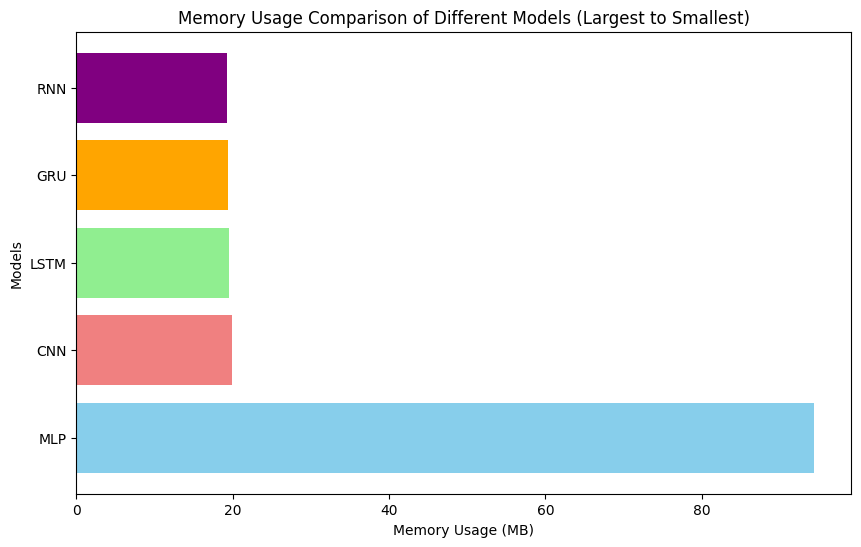

In [ ]:
import matplotlib.pyplot as plt

memory_usages = {
    'RNN': memory_RNN,
    'MLP': memory_MLP,
    'LSTM': memory_LSTM,
    'GRU': memory_GRU,
    'CNN': memory_CNN
}

#TRI
sorted_memory_usages = dict(sorted(memory_usages.items(), key=lambda item: item[1], reverse=True))

models = list(sorted_memory_usages.keys())
memory = list(sorted_memory_usages.values())

plt.figure(figsize=(10, 6))
plt.barh(models, memory, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'purple'])
plt.xlabel("Memory Usage (MB)")
plt.ylabel("Models")
plt.title("Memory Usage Comparison of Different Models (Largest to Smallest)")
plt.show()

On observe que les modèles **RNN, GRU, LSTM et CNN** (20MB) utilisent moins de mémoire que les **MLP** (100MB env).

Cela est probablement dû à la manière dont ces modèles gèrent les paramètres : les architectures récurrentes et convolutifs partagent des poids à travers les étapes temporelles/filtres, ce qui réduit le besoin en mémoire.

En revanche, les MLP qui sont des réseaux entièrement connectés, nécessitent beaucoup plus de mémoire car **chaque neurone est connecté à tous les neurones de la couche suivante**, créant ainsi **un grand nombre de paramètres à stocker**.

## 6.4. Combinaisons des méthodes :

Nous combinons maintenant les prédictions des modèles vus précedement (RNN, LSTM, GRU, MLP et CNN) en utilisant un classificateur d'ensemble basé sur le **vote majoritaire**. Chaque modèle prédit si un échantillon appartient à une classe, et l'ensemble détermine la classe finale en tenant compte de la majorité des votes. La précision du classificateur d'ensemble est évaluée et comparée à celle des modèles individuels.

A t-on que l'ensemble des modèles peut améliorer les performances globales en atténuant les erreurs spécifiques à chaque modèle ? (oui)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
#CLASSIFIEUR PAR VOTE MAJORITARE
def ensemble_classifier(predictions):
    ensemble_preds = []
    num_samples = len(predictions[0])

    for i in range(num_samples):  # chaque modele
        votes = [pred[i] for pred in predictions]
        ensemble_preds.append(np.bincount(votes).argmax())

    return np.array(ensemble_preds)

# Prediction par modèle
preds_RNN = model_RNN.predict(X_test).flatten() > 0.5
preds_LSTM = model_LSTM.predict(X_test).flatten() > 0.5
preds_GRU = model_GRU.predict(X_test).flatten() > 0.5
preds_MLP = model_MLP.predict(X_test).flatten() > 0.5
preds_CNN = model_CNN.predict(X_test).flatten() > 0.5

#Dictionnaire
predictions_dict = {
    "RNN": preds_RNN,
    "LSTM": preds_LSTM,
    "GRU": preds_GRU,
    "MLP": preds_MLP,
    "CNN": preds_CNN
}

# Converti les probas en (0 ou 1)
all_predictions = list(predictions_dict.values())
ensemble_predictions = ensemble_classifier(all_predictions)

# Evaluation de l'ensemble classifier
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

# Evaluation des modeles individuellement
for model_name, preds in predictions_dict.items():
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy of {model_name} model:", accuracy)
    if ensemble_accuracy > accuracy:
        print(f"Ensemble method improves upon the {model_name} model.")
    print()


782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Ensemble Accuracy: 0.88944
Accuracy of RNN model: 0.83
Ensemble method improves upon the RNN model.

Accuracy of LSTM model: 0.8734
Ensemble method improves upon the LSTM model.

Accuracy of GRU model: 0.87652
Ensemble method improves upon the GRU model.

Accuracy of MLP model: 0.83324
Ensemble method improves upon the MLP model.

Accuracy of CNN model: 0.88804
Ensemble method improves upon the CNN model.



Les résultats montrent que le classificateur d'ensemble atteint une **précision de 88,94%**, ce qui est meilleur que tous des modèles individuels. Voici les performances des modèles :


* **Modèle 1 (RNN)** : Précision de 83% → L'ensemble améliore largement ce modèle.
* **Modèle 2 (LSTM)** : Précision de 87,34% → L'ensemble améliore également ce résultat.
* **Modèle 3 (GRU)** : Précision de 87,65% →  L'ensemble améliore également ce résultat.
* **Modèle 4 (CNN)** : Précision de 88,8% →  L'ensemble améliore également ce résultat.
* **Modèle 5 (MLP)** : Précision de 83,32% → L'ensemble améliore largement ce modèle.


En conclusion, le classificateur d'ensemble parvient à consolider les forces des différents modèles pour atteindre une précision globalement meilleure.

Interprétation :

Le classificateur d'ensemble améliore les performances globales en combinant les forces de chaque modèle, ce qui permet de mieux capturer les caractéristiques de la tâche. En réduisant les erreurs individuelles et en offrant une plus grande stabilité, l'ensemble obtient une meilleure précision que les modèles pris séparément.


# **Conclusion :**
Pour classifier des critiques de films en positifs et négatifs :

Nous choisissons **CNN** car il offre la meilleure performance, un temps d'entraînement rapide et une faible consommation de mémoire. Si vous souhaitez améliorer la précision, vous pouvez utiliser un modèle **de vote majoritaire** pour augmenter légèrement la précision, mais cela nécessite d'entraîner au préalable les 5 modèles, ce qui consomme davantage de ressources.

# 7. BONUS : Pré-entraînement avec des données non étiquetées

## 7.0. Préparation de données non étiquetées pour le pré-entraînement

In [ ]:
def load_unsup_data(path):
    data = []
    unsup_path = os.path.join(path, 'unsup')
    if os.path.exists(unsup_path):
        for filename in os.listdir(unsup_path):
            with open(os.path.join(unsup_path, filename), 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
    return data

# Load unlabeled data
unsup_data = load_unsup_data('aclImdb/train')

# Create DataFrame
unsup_df = pd.DataFrame(unsup_data, columns=['text'])

# Preprocess data
tokenizer = Tokenizer(num_words=10000)  # Considering the top 10,000 most frequent words
tokenizer.fit_on_texts(unsup_df['text'])

X_unsup = tokenizer.texts_to_sequences(unsup_df['text'])

# Pad sequences to a fixed length
maxlen = 300  # Adjust as needed
X_unsup = pad_sequences(X_unsup, maxlen=maxlen)

print("Unlabeled dataset dimensions:")
print(f"X_unsup: {X_unsup.shape}")

Unlabeled dataset dimensions:
X_unsup: (50000, 300)


## 7.1. Pre-entraînement des données IMDB via un VAE

Nous créeons un modèle de Variational Autoencoder (VAE) pour traiter les séquences de texte dans une tâche non supervisée. Le modèle est entraîné pour apprendre à **encoder des séquences dans un espace latent de dimension réduite et à reconstruire les séquences à partir de cet espace latent**. La perte est calculée en fonction de la reconstruction des données et de la divergence de Kullback-Leibler entre la distribution latente et la distribution normale.

* **Perte $\mathcal{L}_{\text{total}}$ :**

La perte totale est la somme de la perte de reconstruction et de la perte KL, elle est calculée à chaque itération et guide l'optimisation des paramètres du modèle :

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{reconstruction}} + \mathcal{L}_{\text{KL}}$$

La perte de reconstruction mesure la différence entre les données d'entrée originales et les données reconstruites par le modèle:

$$\mathcal{L}_{\text{reconstruction}} = - \mathbb{E}_{q(z|x)} \left[ \log p(x|z) \right]$$

où $( x )$ est la séquence d'entrée des critiques de films, et $ p(x|z) $ est la probabilité des données reconstruites à partir de l'échantillon latent $( z )$ générée par le décodeur du VAE.

La divergence de Kullback-Leibler mesure la différence entre la distribution $q(z|x)$ (la distribution de  $z$ donnée $x$ sous l'encodeur) et la distribution *prior* $p(z)$ qui est une loi $\mathcal{N}(0, I)$ :

$$\mathcal{L}_{\text{KL}} = - \frac{1}{2} \mathbb{E}_{q(z|x)} \left[ 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right]$$
Avec :
- $ \mu $ est la moyenne (mean) du vecteur latent $( z )$,
- $ \sigma^2$ est la variance (log-variance) du vecteur latent $( z )$.

Cette perte mesure la distance entre la distribution latente apprise et la distribution prior $\mathcal{N}(0, I)$ et contraint donc le modèle à apprendre une distribution latente qui est proche de la distribution normale.

* **Reparamétrisation trick** :

Ensuite on échantillonne à partir de la distribution $\mathcal{N}(\mu, \sigma^2)$ de manière différentiable. Il permet un échantillonnage différentiable et stable, facilitant l'optimisation des modèles $z = \mu + \sigma \cdot \epsilon$ où    $\epsilon \sim \mathcal{N}(0, I)$ est un bruit aléatoire tiré d'une distribution normale standard, et $\sigma = \exp(0.5 \log(\sigma^2))$.

* **vocab_size_VAE = 10000**: Le vocabulaire est limité à 10 000 mots pour couvrir une large gamme de termes courants tout en évitant un surapprentissage lié aux mots rarement employés.

* **embedding_dim_VAE = 128**: La dimension des embeddings est fixée à 128 pour capturer les relations sémantiques entre les mots sans surcharger la mémoire.

* **maxlen_VAE = 300 :** La longueur maximale des séquences est de 300 mots pour couvrir la plupart des critiques tout en maintenant une efficacité en termes de coût des calculs.

* **conv_filters = 128**: Le modèle utilise 128 filtres Conv1D pour extraire suffisamment de caractéristiques sans sacrifier la performance ni la vitesse.

* **kernel_size = 5 :** La taille du noyau Conv1D est de 5, permettant de capturer des mots locaux dans les critiques.

* **latent_dim_VAE = 64 :** La dimension de l'espace latent est de 64 pour apprendre une représentation compacte tout en évitant le sur-ajustement.

* **dropout_rate_VAE = 0.3**: Un taux de dropout de 30 % aide à prévenir le sur-apprentissage en désactivant aléatoirement des neurones pendant l'entraînement.

* **batch_size_VAE = 50**: Ce choix est jugé raisonnable car il représente un diviseur commun entre la taille des ensembles d'entraînement, de validation et de test. Cela garantit une répartition équilibrée des données dans chaque batch tout en optimisant les performances et la consommation de mémoire.

* **epochs_VAE = 5 :** Le modèle est entraîné pendant 5 époques, un nombre suffisant pour une bonne convergence sans risque de sur-ajustement.

* **learning_rate_VAE = 0.001**: Le taux d'apprentissage de 0.001 est choisi pour permettre une convergence stable tout en étant suffisamment rapide.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import time
from tqdm import tqdm


train_size_unsup = int(0.8 * len(X_unsup))
X_train_unsup = X_unsup[:train_size_unsup]
X_val_unsup = X_unsup[train_size_unsup:]

# Define parameters
vocab_size_VAE = 10000  # Vocabulary size
embedding_dim_VAE = 128  # Embedding size
maxlen_VAE = 300  # Maximum sequence length
conv_filters = 128  # Number of Conv1D filters
kernel_size = 5  # Kernel size for Conv1D
latent_dim_VAE = 64  # Latent space dimension
dropout_rate_VAE = 0.3  # Dropout rate
batch_size_VAE = 50  # Batch size
epochs_VAE = 5  # Number of epochs
learning_rate_VAE = 0.001  # Learning rate

# Build the VAE model
encoder_unsup = Sequential([
    Embedding(input_dim=vocab_size_VAE, output_dim=embedding_dim_VAE, input_length=maxlen_VAE),
    Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate_VAE),
    GlobalMaxPooling1D(),
    Dense(latent_dim_VAE * 2)
])

decoder_unsup = Sequential([
    Dense(conv_filters, activation='relu', input_shape=(latent_dim_VAE,)),
    Dense(maxlen_VAE * embedding_dim_VAE, activation='relu'),
    Reshape((maxlen_VAE, embedding_dim_VAE)),
    Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'),
    Dense(vocab_size_VAE, activation='softmax')
])

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=-1)
        z = self.reparameterize(z_mean, z_log_var)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

vae_unsup = VAE(encoder_unsup, decoder_unsup, latent_dim_VAE)

def vae_loss(model, x):
    reconstruction, z_mean, z_log_var = model(x)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(x, reconstruction)
    )
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    total_loss = reconstruction_loss + kl_loss
    return total_loss

optimizer = Adam(learning_rate=learning_rate_VAE)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = vae_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(model, x):
    loss = vae_loss(model, x)
    return loss

# Create dataset and batch
train_dataset_unsup = tf.data.Dataset.from_tensor_slices(X_train_unsup).shuffle(buffer_size=len(X_train_unsup)).batch(batch_size_VAE)
val_dataset_unsup = tf.data.Dataset.from_tensor_slices(X_val_unsup).batch(batch_size_VAE)

# Function to shuffle some words in the input sequence
def shuffle_words(batch, shuffle_prob=0.15):
    def shuffle_sequence(sequence):
        sequence = sequence.numpy()
        indices = tf.range(tf.shape(sequence)[0])
        shuffled_indices = tf.random.shuffle(indices)
        return tf.gather(sequence, shuffled_indices)

    shuffled_batch = []
    for seq in batch:
        if tf.random.uniform([]) < shuffle_prob:
            shuffled_seq = tf.py_function(shuffle_sequence, [seq], tf.int32)
            shuffled_batch.append(shuffled_seq)
        else:
            shuffled_batch.append(seq)
    return tf.stack(shuffled_batch)

# Train the model
start_time = time.time()
shuffle_prob = 0.3  # Probability of shuffling a sequence

for epoch in range(epochs_VAE):
    total_loss = 0
    total_val_loss = 0

    # Training
    print(f'Epoch {epoch + 1}/{epochs_VAE}')
    for x_batch in tqdm(train_dataset_unsup, desc='Training'):
        # Apply shuffling
        x_batch_shuffled = shuffle_words(x_batch, shuffle_prob)
        loss = train_step(vae_unsup, x_batch_shuffled, optimizer)
        total_loss += loss

    avg_loss = total_loss / len(train_dataset_unsup)

    # Validation
    for x_batch in tqdm(val_dataset_unsup, desc='Validation'):
        val_loss = val_step(vae_unsup, x_batch)
        total_val_loss += val_loss

    avg_val_loss = total_val_loss / len(val_dataset_unsup)

    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

end_time = time.time()
execution_time_VAE = end_time - start_time
print(f"VAE Execution Time: {execution_time_VAE:.2f} seconds")

# Save trained encoder weights
vae_unsup.encoder.save_weights('vae_encoder_weights.weights.h5')

# Print model summaries
vae_unsup.encoder.summary()
vae_unsup.decoder.summary()


Epoch 1/5


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.12it/s]


Epoch 1, Loss: 4.6446, Val Loss: 4.3721
Epoch 2/5


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.45it/s]


Epoch 2, Loss: 4.4149, Val Loss: 4.2600
Epoch 3/5


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


Epoch 3, Loss: 4.3677, Val Loss: 4.2351
Epoch 4/5


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.59it/s]


Epoch 4, Loss: 4.3500, Val Loss: 4.2272
Epoch 5/5


Validation: 100%|██████████| 200/200 [00:08<00:00, 24.56it/s]

Epoch 5, Loss: 4.3382, Val Loss: 4.2342
VAE Execution Time: 688.29 seconds


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (50, 300, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (50, 296, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (50, 148, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (50, 148, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (50, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (50, 128)                   │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,560 (5.26 MB)

 Trainable params: 1,378,560 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 38400)               │       4,953,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 300, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 300, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 300, 10000)          │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,333,968 (24.16 MB)

 Trainable params: 6,333,968 (24.16 MB)

 Non-trainable params: 0 (0.00 B)

##7.2. Affinage avec un Encodeur Pré-entraîné

Nous allons maintenant **réutiliser** les caractéristiques extraites lors de l'entraînement précédent et y ajouter un modèle **CNN supplémentaire**  après l'encodeur pour adapter le réseau à la tâche spécifique d'analyse de sentiments. Cela comprend des **couches denses** et une **couche de sortie avec activation sigmoid pour la classification binaire :**

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$

Où :

$$z = \mathbf{w} \cdot \mathbf{x} + b$$

- $\hat{y}$ représente la probabilité prédite par le modèle (entre 0 et 1).
- $z$ est la sortie linéaire du neurone.
- $\mathbf{w}$ est le vecteur des poids.
- $\mathbf{x}$ est le vecteur des entrées.
- $b$ est le biais.



* **Fine-tuning des poids :**

Le **nombre d'époques est augmenté à 20** et un **taux d'apprentissage plus faible (1e-4)** est utilisé pour éviter de perturber les poids pré-existants. Un **early stopping** est aussi mis en place pour stopper l'entraînement si la perte de validation ne s'améliore plus au bout de 3 époques consécutives.

In [ ]:
# Define parameters for the fine-tuning model
vocab_size_sup = 10000
embedding_dim_sup = 128
maxlen_sup = 300
conv_filters = 128
kernel_size = 5
dropout_rate_sup = 0.3
batch_size_sup = 50
epochs_sup = 20
learning_rate_sup = 1e-4
early_stopping_sup = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Use the encoder from the pre-trained VAE model
encoder_sup = Sequential([
    Embedding(input_dim=vocab_size_sup, output_dim=embedding_dim_sup, input_length=maxlen_sup),
    Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(dropout_rate_sup),
    GlobalMaxPooling1D()
])

# Build the model before loading weights
encoder_sup.build(input_shape=(None, maxlen_sup))

# Load the pre-trained encoder weights
encoder_sup.load_weights('vae_encoder_weights.weights.h5')

# Set all layers as trainable
for layer in encoder_sup.layers:
    layer.trainable = True

# Create a new CNN model using the pre-trained encoder
inputs_sup = Input(shape=(maxlen_sup,))
x_sup = encoder_sup(inputs_sup)

# Add subsequent layers
x_sup = Dense(128, activation='relu')(x_sup)
x_sup = Dropout(0.3)(x_sup)
outputs_sup = Dense(1, activation='sigmoid')(x_sup)

model_sup = Model(inputs=inputs_sup, outputs=outputs_sup)

# Compile the model
model_sup.compile(optimizer=Adam(learning_rate=learning_rate_sup),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
start_time_sup = time.time()
history_sup = model_sup.fit(
    X_train, y_train,
    epochs=epochs_sup,
    batch_size=batch_size_sup,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_sup]
)
end_time_sup = time.time()

# Evaluate on the test set
test_loss_sup, test_accuracy_sup = model_sup.evaluate(X_test, y_test)
print(f"Test Loss (sup): {test_loss_sup:.4f}")
print(f"Test Accuracy (sup): {test_accuracy_sup:.4f}")

execution_time_sup = end_time_sup - start_time_sup
print(f"Execution Time: {execution_time_sup:.2f} seconds")

# Print model summary
model_sup.summary()


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5185 - loss: 0.7112 - val_accuracy: 0.6160 - val_loss: 0.6766
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5935 - loss: 0.6675 - val_accuracy: 0.6898 - val_loss: 0.6414
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6836 - loss: 0.6111 - val_accuracy: 0.7460 - val_loss: 0.5686
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7625 - loss: 0.5120 - val_accuracy: 0.7988 - val_loss: 0.4765
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8117 - loss: 0.4240 - val_accuracy: 0.8206 - val_loss: 0.4177
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8534 - loss: 0.3440 - val_accuracy: 0.8420 - val_loss: 0.3729
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8881 - loss: 0.2812 - val_accuracy: 0.8572 - val_loss: 0.3433
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9126 - loss: 0.2359 - val_accuracy: 0.

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 128)                 │       1,362,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,136,069 (15.78 MB)

 Trainable params: 1,378,689 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,757,380 (10.52 MB)

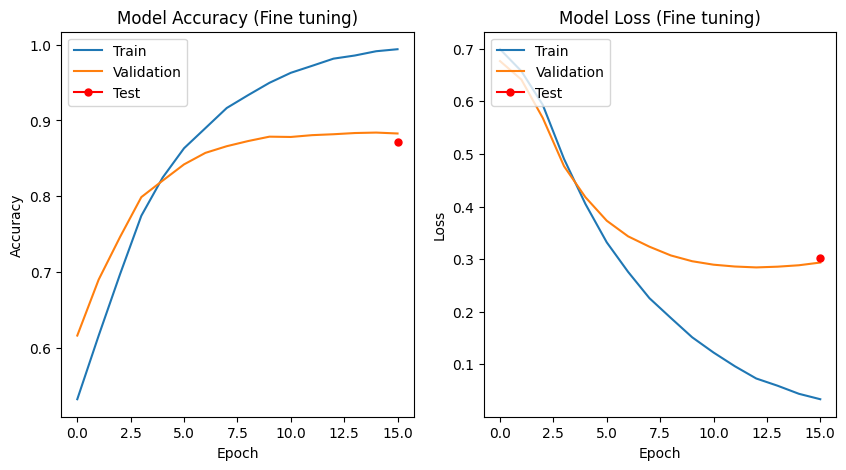

In [ ]:
# Visualisation de la courbe de perte et d'exactitude
# Tracer la précision d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sup.history['accuracy'])
plt.plot(history_sup.history['val_accuracy'])
plt.plot([len(history_sup.history['accuracy'])-1], [test_accuracy_sup], marker='o', markersize=5, color='red', label='Test') # Added test accuracy
plt.title('Model Accuracy (Fine tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')

# Tracer la perte d'entraînement et de validation
plt.subplot(1, 2, 2)
plt.plot(history_sup.history['loss'])
plt.plot(history_sup.history['val_loss'])
plt.plot([len(history_sup.history['loss'])-1], [test_loss_sup], marker='o', markersize=5, color='red', label='Test') # Added test loss
plt.title('Model Loss (Fine tuning)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()


Le modèle présente une excellente performance sur les données d'entraînement (accuracy de 0.99 et erreur de 0.03), mais une performance légèrement inférieure sur les données de validation/test (accuracy de 0.88 et erreur de 0.29).

Les résultats montrent que le **finetuning** sur certaines couches pré-entraînées pour le **VAE** avec des données **non étiquetées** (non supervisées) n'améliore pas les performances du modèle **CNN**. Cela peut être dû au fait que les couches ont été entraînées sur une tâche différente, qui n'est pas complètement adaptée à l'objectif actuel, ce qui ne bénéficie pas au modèle CNN dans la tâche de classification.